###  

qsec 컬럼 최소최대 척도(Min-Max Scale)로 변환 후 0.5보다 큰 값을 가지는 레코드 수

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('1유형/mtcars.csv')
df.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


####  calculation

In [9]:
qsec_min, qsec_max = df['qsec'].min(), df['qsec'].max()
print(qsec_min)
print(qsec_max)

14.5
22.9


In [15]:
mm = (df['qsec']-df['qsec'].min())/(df['qsec'].max()-df['qsec'].min())
print(f'ANSWER : {(mm>0.5).sum()}')

ANSWER : 9


####  MinMaxScaler

In [17]:
from sklearn import preprocessing
import numpy as np

In [32]:
qsec = np.array(df['qsec']).reshape(-1,1) # 1D array for sklearn preprocessing MinMaxScaler
qsec[:3]

array([[16.46],
       [17.02],
       [18.61]])

In [36]:
mm_scaler = preprocessing.MinMaxScaler()
qsec = mm_scaler.fit_transform(qsec)
print(f'ANSWER : {np.where(qsec>0.5,1,0).sum()}')

ANSWER : 9


###  

- 백화점 고객 1년치 데이터
    1. y_train.csv : 고객의 성별 데이터 (학습, 3500명)
    2. X_train.csv, X_test.csv : 고객의 상품구매 속성(학습용 / 평가용, 3500명 / 2482명)
    
    
- 3500명 학습용 데이터 이용하여 성별예측모형 구현
- 평가용 데이터 X_test 를 적용하여 얻은 2482명의 **고객 성별 예측값(남자일 확률)** csv 파일로 제출
    - 파일명 : 수험번호.csv


- 제출 모델 성능 평가 : ROC-AUC

#### module import

In [72]:
# data
import pandas as pd
import numpy as np

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font', family='Malgun Gothic') 

#### data load

In [106]:
X_train = pd.read_csv('2유형/X_train.csv', encoding='CP949')
X_test = pd.read_csv('2유형/X_test.csv', encoding='CP949')
y_train = pd.read_csv('2유형/y_train.csv', encoding='CP949')

In [107]:
X_train.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


In [108]:
# X cust_id 제거
X_train.drop('cust_id', axis=1, inplace=True)
X_test.drop('cust_id', axis=1, inplace=True)
y_train.drop('cust_id', axis=1, inplace=True)

In [109]:
X_train.head(1)

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17


#### preprocessing

In [110]:
X_train.isnull().sum()

총구매액          0
최대구매액         0
환불금액       2295
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [111]:
X_test.isnull().sum()

총구매액          0
최대구매액         0
환불금액       1611
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   총구매액     3500 non-null   int64  
 1   최대구매액    3500 non-null   int64  
 2   환불금액     1205 non-null   float64
 3   주구매상품    3500 non-null   object 
 4   주구매지점    3500 non-null   object 
 5   내점일수     3500 non-null   int64  
 6   내점당구매건수  3500 non-null   float64
 7   주말방문비율   3500 non-null   float64
 8   구매주기     3500 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 246.2+ KB


**전처리 필요 항목**
- 환불금액 null 처리
- 주구매상품, 주구매지점 라벨인코딩

In [113]:
# X_train['환불금액']=X_train['환불금액'].fillna(0)
X_train['환불금액']=np.where(X_train['환불금액'].isnull()==True, 0,X_train['환불금액'])
X_test['환불금액']=np.where(X_test['환불금액'].isnull()==True, 0,X_test['환불금액'])
X_train.isnull().sum()

총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
dtype: int64

In [114]:
X_train[['주구매상품', '주구매지점']] = X_train[['주구매상품', '주구매지점']].apply(LabelEncoder().fit_transform)
X_test[['주구매상품', '주구매지점']] = X_train[['주구매상품', '주구매지점']].apply(LabelEncoder().fit_transform)

In [115]:
X_train.head(2)

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,5,0,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,21,19,2,1.500000,0.000000,1


In [116]:
X_test.head(2)

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,70900400,22000000,4050000.0,5,0,13,1.461538,0.789474,26
1,310533100,38558000,48034700.0,21,19,90,2.433333,0.369863,3


#### (+a) EDA & Feature Engineering

In [51]:
df = pd.concat([X_train, y_train], axis=1)
df.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0


In [117]:
df = pd.concat([X_train, y_train], axis=1)
df.columns

Index(['총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수', '주말방문비율',
       '구매주기', 'gender'],
      dtype='object')

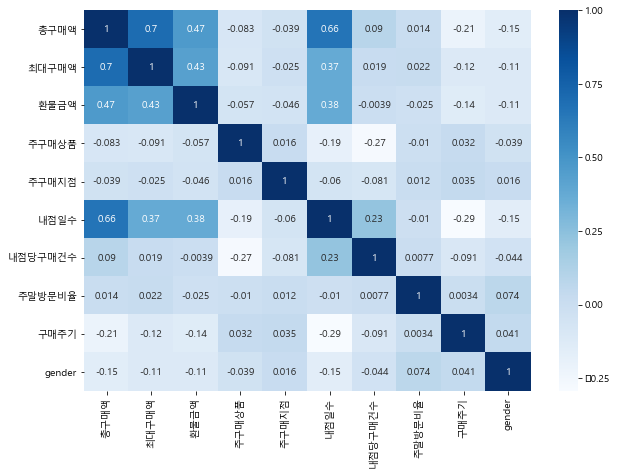

In [124]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True, cmap = "Blues")

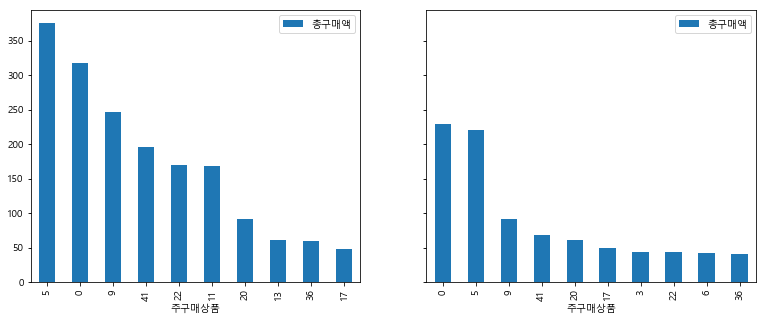

In [126]:
fig, axes = plt.subplots(ncols=2,figsize=(13,5), sharey=True)
df.query('gender==0').pivot_table(index='주구매상품', 
                                  values='총구매액', aggfunc='count').sort_values('총구매액', ascending=False).head(10).plot(kind='bar',ax=axes[0])
df.query('gender==1').pivot_table(index='주구매상품', 
                                  values='총구매액', aggfunc='count').sort_values('총구매액', ascending=False).head(10).plot(kind='bar',ax=axes[1])

- 남성 여성 구매 패턴 다름
- 양의 상관관계 존재 : 총구매액 & 내점일수 

#### Modeling 

##### Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

# Training
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=20, n_jobs=2)
rfc.fit(X_train,y_train)

#prediction
rfc_predict=rfc.predict(X_test)

C:\Users\JIIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [133]:
print(f'Random Forest Training Accuracy: {rfc.score(X_train, y_train)}')

Random Forest Training Accuracy: 0.9994285714285714


In [142]:
y_submit = pd.read_csv('2유형/X_test.csv', encoding='CP949')
y_submit=y_submit['cust_id']

In [143]:
submission = pd.concat([y_submit, pd.Series(rfc_predict)], axis=1)
submission.head()
# submission.to_csv('submission_randomforest.csv')

,cust_id,0
0,3500,0
1,3501,0
2,3502,0
3,3503,1
4,3504,0


In [ ]:
#### 